# Self-assigned-project

In [1]:
# Import base tools
import os, sys
from pathlib import Path
sys.path.append(os.path.join(".."))
import cv2

# Import data analysis
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm

# Import tensorflow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# Import teaching utils 
from utils.styletransfer import *
#from utils.imutils import jimshow

# Import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Import seaborn for data vizualisations:
import seaborn as sns

# Import Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

# Import skelearn metrics
from sklearn.metrics import classification_report,confusion_matrix

# Import splitfolders to segment data into training- and testing data:
import splitfolders

# Suppress warnings:
import warnings
warnings.filterwarnings('ignore')

### Loading data:

In [2]:
# Load a Tensorflow-Hub model for image style transfer (see https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2 for info):
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

In [3]:
#Load style-image data (note, I have manually removed the image titled "9223372032559844173.jpg", since it was corrupt):
style_images = [] # Create empty list for appending file-names.
filepath = os.path.join("raw_data", "monet") # Define the filepath to the Monet-images.
for image in Path(filepath).glob("*.jpg"): # For each file (image) with the extension ".jpg" in "filepath"...
    style_images.append(image) # ... Append file to "style_images"-list.

In [4]:
#Load content-image data:
content_images = [] # Create empty list for appending file-names.
filepath = os.path.join("raw_data","content_images") # Define the filepath to the content-images.
for image in Path(filepath).glob("*.jpg"): # For each file (image) with the extension ".jpg" in "filepath"...
    content_images.append(image) # ... Append file to "content_images"-list.

In [5]:
#Assess if the data has been loaded correctly (sanity check):
print(len(content_images),len(style_images))


4341 398


### Performing style transfer and saving images:

In [6]:
# Performing style transfer:
stylized_image = [] # Creating empty list for appending stylized images.
filename = [] # Create empty list for appending filenames.
for con, style in zip(content_images, style_images): # For each content and style image in "content_images" and "style_images", respectively 
    content_image = st_load(con) # ... Load the content image
    style_image = st_load(style) # ... Load the style image
    outputs = hub_module(content_image, style_image) # ... Perform style transfer using the loaded hub-module and save the image as outputs
    stylized_image.append(outputs[0]) # ... Append the output-image to the "stylized_image"-list.
    filename.append(f"cont_{Path(con).stem}_style_{Path(style).stem}_merge.jpg") # ... Append the filename to the "filename"-list.

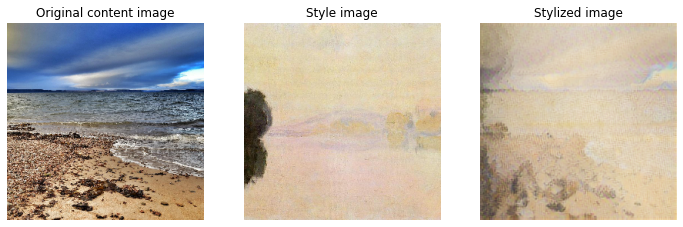

In [7]:
#See if it worked (sanity check):
show_n([content_image, style_image, stylized_image[397]], 
       titles=['Original content image', 'Style image', 'Stylized image'])

In [8]:
#Saving images:
for i, name in zip(list(range(0,len(stylized_image))), filename): # For each number between zero and the amount of stylized images & each name in the "filename"-list.
    img = np.asarray(stylized_image[i])[0] # Convert the image to a numpy-array.
    img = img[:,:,::-1] # Invert RGB 
    cv2.imwrite(f"mangled_data/fake_images/fake_{name}", img*255) # Write the image to the specified directory and multiply each pixel-value by 255.

### Preprocess data for CNN

In [9]:
# Split data into training and testing data:
splitfolders.ratio('mangled_data', output="split_data", seed=1337, ratio=(.8, 0.0, 0.2)) # Split the data in "mangled_data" into the "split_data"-folder. 80% should go to the training-set and 20% to the testing set. Seed is set for reproducibility. 

Copying files: 796 files [00:00, 933.26 files/s] 


In [10]:
# Define function to load the data and convert it into a suitable format for the CNN correct format:
labels = ['monet', 'fake_images'] # Define the data-classes in a list called "labels"

def get_data(directory): # Define function called "get_data" that takes "directory" as input variable:
    data = [] # Define empty list called "data".
    for label in labels: # For each label in the list "labels" ...
        path = os.path.join(directory, label)  # ... Specify the path as "directory/label" 
        class_num = labels.index(label) # ... Specify "class_num" as the index of the current label in the "labels"-list (i.e. monet = 0 and fake_iamges = 1)
        for img in os.listdir(path): # For each image in "path" ...
            img_arr = cv2.imread(os.path.join(path, img))[...,::-1] # Read the image, convert BGR to RGB-format and save it as "img_arr"
            resized_arr = cv2.resize(img_arr, (256, 256)) # ... Reshape the image to 256 x 256
            data.append([resized_arr, class_num]) # Append the image to the "data"-list as the first element and the class as the second element. 
    return np.array(data) # When done, convert data to a numpy-array.

In [11]:
# Load train- and test data:
train = get_data("split_data/train") 
test = get_data("split_data/test")

<AxesSubplot:ylabel='count'>

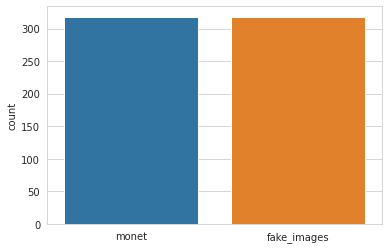

In [12]:
# Plot bar diagram og classes in training data to ensure that the data has been split equally across classes (sanity check):
category = [] # Define empty list "l"
for i in train: # For each element in training data
    if(i[1] == 0): # ... If the class of "train" = 0...
        category.append("monet") # ... Append "monet" to the "category"-list
    else: # If the class is not zero (i.e. 1)...
        category.append("fake_images") # ... Append "fake_images" to the "category"-list
sns.set_style('whitegrid') # Set style of seaborn-plot as "whitegrid"
sns.countplot(category) # Create a countplot of the "category"-list

Text(0.5, 1.0, 'monet')

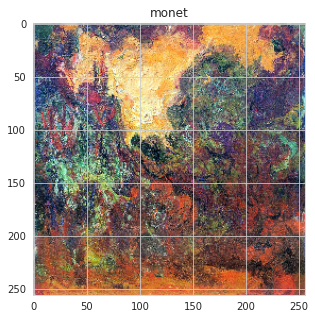

In [13]:
# Plotting monet-image (sanity check):
plt.figure(figsize = (5,5)) # Define matplotlib "drawing-board"
plt.imshow(train[1][0]) # Plot the first image in "train" (i.e. the first element of the first element in "train")
plt.title(labels[train[1][1]]) # Plot the category of the first image in "train" (i.e. the second element of the first element in "train")

Text(0.5, 1.0, 'fake_images')

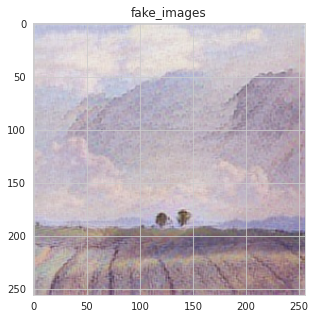

In [14]:
# Repeating above for a fake image (sanity check)
plt.figure(figsize = (5,5))
plt.imshow(train[-2][0]) # Taking the second last entry in "train"
plt.title(labels[train[-2][1]]) # Taking the second last entry in "train"

In [15]:
# Data preprocesing:

# Define empty lists for data. The x's are for images and the y's are for classes. I'm using the same data for testing and validation.
x_train = [] 
y_train = []
x_test = []
y_test = []

# Create training data:
for array, label in train: # For each array (first element) and each label (second element) in train...
    x_train.append(array) # ... Append array to "x_train".
    y_train.append(label) # ... Append label to "y_train"

for array, label in test: # For each array (first element) and each label (second element) in test...
    x_test.append(array) # ... Append array to "x_test".
    y_test.append(label) # ... Append label to "y_test"

# Normalizing the pixel range for 0 -> 255 to 0 -> 1:
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255

# Converting labels to array-format:
y_train = np.array(y_train)
y_test = np.array(y_test)

### Create CNN-classifier from scratch:

In [16]:
# Creating CNN-model:
model = Sequential() # Initializing model.
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(256,256,3))) # Adding first convolutional layer. 
model.add(MaxPool2D(2,2)) # Adding first maxppoling layer. Downsampling image with a maxpool makes the model computations less heavy (due to less parameters). Furthermore, it also makes the model more generalizable since it comes to rely less on exact features in the input image.

model.add(Conv2D(32, 3, padding="same", activation="relu")) # Adding second convolutional layer. 
model.add(MaxPool2D(2,2)) # Adding second maxpooling layer.

model.add(Conv2D(64, 3, padding="same", activation="relu")) # Adding third convolutional layer. 
model.add(MaxPool2D(2,2)) # Adding third maxppoling layer.
model.add(Dropout(0.6)) # Adding dropout layer, which sets 40% of the layer inputs to 0 (to avoid overfitting).

model.add(Flatten()) # Flatten input.
model.add(Dense(128,activation="relu")) # Add a dense layer with 128 output nodes.
model.add(Dense(2, activation="softmax")) # Add a dense layer with 2 output nodes (one for each class).

# Show model summary:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0

In [17]:
# Plot model:

tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [18]:
# Define adam optimizer with a low learning rate.
optimizer = Adam(lr=0.000001) 

# Compile model with SparseCategoricalCrossentropy loss function and the above optimizer.
model.compile(optimizer = optimizer , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [19]:
# Fit the model for 50 epochs:

epochs = 50 # Define epochs-object.

fitted_model = model.fit(x_train, y_train, epochs = epochs, validation_data = (x_test, y_test)) #Fit model. Use testing data as validation data.

Epoch 1/50
20/20 [==============================] - 41s 2s/step - loss: 0.6990 - accuracy: 0.5418 - val_loss: 0.6928 - val_accuracy: 0.4938
Epoch 2/50
20/20 [==============================] - 33s 2s/step - loss: 0.6963 - accuracy: 0.5257 - val_loss: 0.6904 - val_accuracy: 0.5125
Epoch 3/50
20/20 [==============================] - 34s 2s/step - loss: 0.6976 - accuracy: 0.4964 - val_loss: 0.6904 - val_accuracy: 0.5000
Epoch 4/50
20/20 [==============================] - 35s 2s/step - loss: 0.6962 - accuracy: 0.4690 - val_loss: 0.6901 - val_accuracy: 0.5000
Epoch 5/50
20/20 [==============================] - 34s 2s/step - loss: 0.6863 - accuracy: 0.5441 - val_loss: 0.6903 - val_accuracy: 0.5000
Epoch 6/50
20/20 [==============================] - 34s 2s/step - loss: 0.6969 - accuracy: 0.4877 - val_loss: 0.6901 - val_accuracy: 0.5000
Epoch 7/50
20/20 [==============================] - 32s 2s/step - loss: 0.6837 - accuracy: 0.5573 - val_loss: 0.6895 - val_accuracy: 0.5000
Epoch 8/50
20/20 [==

### Plots and metrics:

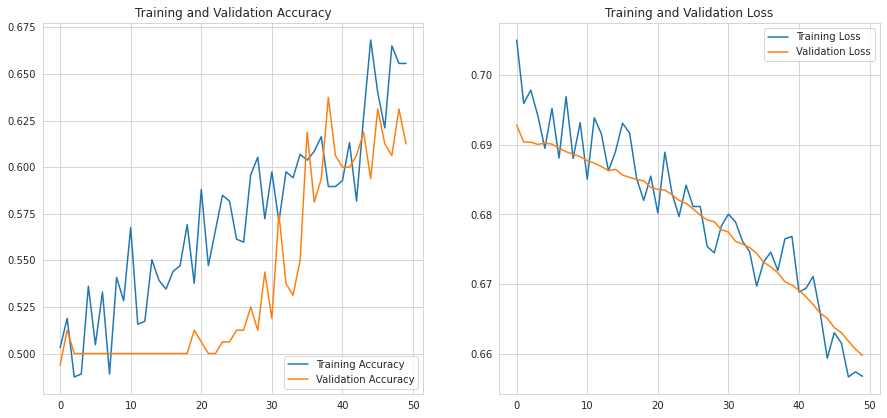

In [20]:
# Plot accuracy and loss as a function of epochs.

acc = fitted_model.history['accuracy'] # Save accuracy history for training data as "acc"
val_acc = fitted_model.history['val_accuracy'] # Save accuracy history for testing data as "val_acc"
loss = fitted_model.history['loss'] # Save loss history for training data as "loss"
val_loss = fitted_model.history['val_loss'] # Save loss history for testing data as "val_loss"

epochs_range = range(epochs) # Define the range of the epochs.

plt.figure(figsize=(15, 15)) # Initialize plot-surface.
plt.subplot(2, 2, 1) # Initialize first subplot.
plt.plot(epochs_range, acc, label='Training Accuracy') # Plot x = "epochs_range", y = "acc".
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot x = "epochs_range", y = "val_acc".
plt.legend(loc='lower right') # Add legend.
plt.title('Training and Validation Accuracy') # Add title.

plt.subplot(2, 2, 2) # Initialize second subplot. 
plt.plot(epochs_range, loss, label='Training Loss') # Plot x = "epochs_range", y = "loss".
plt.plot(epochs_range, val_loss, label='Validation Loss') # Plot x = "epochs_range", y = "val_loss".
plt.legend(loc='upper right') # Add legend.
plt.title('Training and Validation Loss') # Add title.
plt.show() # Print plots

In [21]:
# Predict classes of test data:
predictions = model.predict_classes(x_test)

# Print classification report:
print(classification_report(y_test, predictions, target_names = ['Monet (Class 0)','Fake (Class 1)']))

                 precision    recall  f1-score   support

Monet (Class 0)       0.58      0.82      0.68        80
 Fake (Class 1)       0.70      0.40      0.51        80

       accuracy                           0.61       160
      macro avg       0.64      0.61      0.59       160
   weighted avg       0.64      0.61      0.59       160



Pretty good. Let's see if we can improve F1-score and computational efficiency with a pre-trained model.

### Pre-trained model

In [22]:
# Redefine "get_data"-function to preprocess data to fit transfer-learning model:

labels = ['monet', 'fake_images'] # Define the data-classes in a list called "labels"

def get_data(directory): # Define function called "get_data" that takes "directory" as input variable:
    data = [] # Define empty list called "data".
    for label in labels: # For each label in the list "labels" ...
        path = os.path.join(directory, label)  # ... Specify the path as "directory/label" 
        class_num = labels.index(label) # ... Specify "class_num" as the index of the current label in the "labels"-list (i.e. monet = 0 and fake_iamges = 1)
        for img in os.listdir(path): # For each image in "path" ...
            img_arr = cv2.imread(os.path.join(path, img))[...,::-1] # Read the image, convert BGR to RGB-format and save it as "img_arr"
            resized_arr = cv2.resize(img_arr, (224, 224)) # ... Reshape the image to 224 x 224.
            data.append([resized_arr, class_num]) # Append the image to the "data"-list as the first element and the class as the second element. 
    return np.array(data) # When done, convert data to a numpy-array.


In [23]:
# Load train- and test data:

train = get_data("split_data/train")
test = get_data("split_data/test")

<AxesSubplot:ylabel='count'>

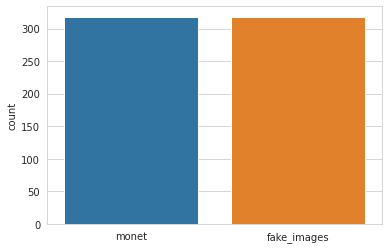

In [24]:
# Plot bar diagram og classes in training data to ensure that the data has been split equally across classes (sanity check):
category = [] # Define empty list "l"
for i in train: # For each element in training data
    if(i[1] == 0): # ... If the class of "train" = 0...
        category.append("monet") # ... Append "monet" to the "category"-list
    else: # If the class is not zero (i.e. 1)...
        category.append("fake_images") # ... Append "fake_images" to the "category"-list
sns.set_style('whitegrid') # Set style of seaborn-plot as "whitegrid"
sns.countplot(category) # Create a countplot of the "category"-list

In [25]:
# Data preprocesing:

# Define empty lists for data. The x's are for images and the y's are for classes. I'm using the same data for testing and validation.
x_train = [] 
y_train = []
x_test = []
y_test = []

# Create training data:
for array, label in train: # For each array (first element) and each label (second element) in train...
    x_train.append(array) # ... Append array to "x_train".
    y_train.append(label) # ... Append label to "y_train"

for array, label in test: # For each array (first element) and each label (second element) in test...
    x_test.append(array) # ... Append array to "x_test".
    y_test.append(label) # ... Append label to "y_test"

# Normalizing the pixel range for 0 -> 255 to 0 -> 1:
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255

# Converting labels to array-format:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [26]:
# Transform the labels to a one-hot tensor (to fit the pretrained model):
y_train = tf.one_hot(y_train, depth=len(labels))
y_test = tf.one_hot(y_test, depth=len(labels))

In [27]:
# Load pretrained model (MobileNetV2) without the final classificaion layer:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape = (224, 224, 3), include_top = False, weights = "imagenet") #

In [28]:
# Freeze model to prevent updating weights in pretrained base-model:
pretrained_model.trainable = False

In [29]:
# Initialize keras-model with some extra layers on top: 
model = tf.keras.Sequential([pretrained_model, 
                                 tf.keras.layers.GlobalAveragePooling2D(), # Add a average pooling layer.
                                 tf.keras.layers.Dropout(0.6), # Add dropout layer, which sets 40% of the layer inputs to 0 (to avoid overfitting).
                                 tf.keras.layers.Dense(2, activation="softmax") # Add a dense layer with 2 output nodes (one for each class).                                     
                                ])

In [30]:
# Plot model:

tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [31]:
# Define adam optimizer with a high learning rate to increase efficiency.
optimizer = Adam(lr = 0.001) 

# Compile model with BinaryCrossentropy loss function and the above optimizer.
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
# Train the model for 10 epochs:

epochs = 10 # Define epochs-object.

fitted_model = model.fit(x_train,y_train,epochs = epochs, validation_data = (x_test, y_test))

Epoch 1/10
20/20 [==============================] - 18s 773ms/step - loss: 0.8486 - accuracy: 0.5847 - val_loss: 0.3569 - val_accuracy: 0.9438
Epoch 2/10
20/20 [==============================] - 14s 700ms/step - loss: 0.3903 - accuracy: 0.8772 - val_loss: 0.2015 - val_accuracy: 0.9688
Epoch 3/10
20/20 [==============================] - 14s 720ms/step - loss: 0.2651 - accuracy: 0.9195 - val_loss: 0.1356 - val_accuracy: 0.9875
Epoch 4/10
20/20 [==============================] - 14s 709ms/step - loss: 0.1934 - accuracy: 0.9534 - val_loss: 0.1027 - val_accuracy: 0.9937
Epoch 5/10
20/20 [==============================] - 13s 672ms/step - loss: 0.1568 - accuracy: 0.9751 - val_loss: 0.0850 - val_accuracy: 0.9937
Epoch 6/10
20/20 [==============================] - 13s 668ms/step - loss: 0.1209 - accuracy: 0.9770 - val_loss: 0.0710 - val_accuracy: 0.9937
Epoch 7/10
20/20 [==============================] - 13s 680ms/step - loss: 0.1055 - accuracy: 0.9809 - val_loss: 0.0612 - val_accuracy: 1.0000

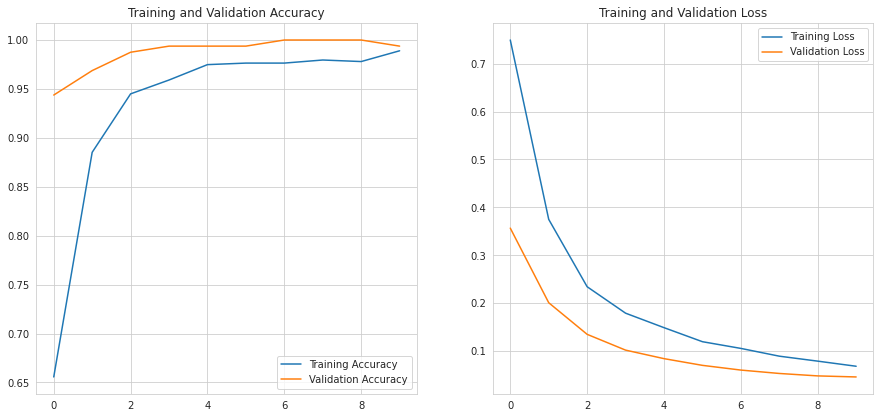

In [33]:
# Plot accuracy and loss as a function of epochs.

acc = fitted_model.history['accuracy'] # Save accuracy history for training data as "acc"
val_acc = fitted_model.history['val_accuracy'] # Save accuracy history for testing data as "val_acc"
loss = fitted_model.history['loss'] # Save loss history for training data as "loss"
val_loss = fitted_model.history['val_loss'] # Save loss history for testing data as "val_loss"

epochs_range = range(epochs) # Define the range of the epochs.

plt.figure(figsize=(15, 15)) # Initialize plot-surface.
plt.subplot(2, 2, 1) # Initialize first subplot.
plt.plot(epochs_range, acc, label='Training Accuracy') # Plot x = "epochs_range", y = "acc".
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot x = "epochs_range", y = "val_acc".
plt.legend(loc='lower right') # Add legend.
plt.title('Training and Validation Accuracy') # Add title.

plt.subplot(2, 2, 2) # Initialize second subplot. 
plt.plot(epochs_range, loss, label='Training Loss') # Plot x = "epochs_range", y = "loss".
plt.plot(epochs_range, val_loss, label='Validation Loss') # Plot x = "epochs_range", y = "val_loss".
plt.legend(loc='upper right') # Add legend.
plt.title('Training and Validation Loss') # Add title.
plt.show() # Print plots

In [34]:
# Recreate testing labels to convert them back to their original format (from a one-hot tensor):
y_test = []

for feature, label in test:
    y_test.append(label)

y_test = np.array(y_test)

In [35]:
# Predict classes of test data:
predictions = model.predict_classes(x_test)

# Print classification report:
print(classification_report(y_test, predictions, target_names = ['Monet (Class 0)','Fake (Class 1)']))

                 precision    recall  f1-score   support

Monet (Class 0)       1.00      0.99      0.99        80
 Fake (Class 1)       0.99      1.00      0.99        80

       accuracy                           0.99       160
      macro avg       0.99      0.99      0.99       160
   weighted avg       0.99      0.99      0.99       160

